In [1]:
from edist.multiprocess import pairwise_distances_symmetric
from edist.uted import uted
from importlib import reload
from sklearn.cluster import OPTICS, cluster_optics_dbscan, DBSCAN, HDBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
import chess
import json
import main
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import pandas as pd
import pickle
import random
import zss
reload(main)
from main import ChessTreeNode, expand_tree

In [ ]:
# Download and unzip stockfish
if not os.path.exists("stockfish"):
    !wget https://github.com/official-stockfish/Stockfish/releases/latest/download/stockfish-ubuntu-x86-64-avx2.tar
    !tar -xf stockfish-ubuntu-x86-64-avx2.tar

In [ ]:
def convert_to_adj_node_lists(t):
    # First we label each node with an integer
    counter = itertools.count()
    idxs = {}
    stack = [t]
    all_nodes = []
    while stack:
        n = stack.pop()
        all_nodes.append(n)
        idxs[id(n)] = next(counter)
        for c in reversed(n.children):
            stack.append(c)
            
    nodes = [None for _ in idxs]
    adj = [None for _ in idxs]

    for n in all_nodes:
        nodes[idxs[id(n)]] = n.move_attributes
        adj[idxs[id(n)]] = [idxs[id(c)] for c in n.children]

    return nodes, adj

In [ ]:
# Read `all_trees`, parse to ChessTreeNode, and load to memory.
trees = {}
with open("../data/trees/condor/all", "r") as f:
    for idx, line in enumerate(tqdm(f.readlines())):
        try:
            puzzle_id, tree = json.loads(line)
        except Exception: # lol
            continue
        if len(tree) == 0:
            continue

        t = ChessTreeNode(*tree[0])
        trees[puzzle_id] = (t, convert_to_adj_node_lists(t))
    with open("tree_dict.pkl", "wb") as f:
        pickle.dump(trees, f)

In [8]:
def compare(t1, t2):
    #return zss.simple_distance(t1, t2, ChessTreeNode.get_children, ChessTreeNode.get_label, ChessTreeNode.compare)
    _, (x_nodes, x_adj) = t1
    _, (y_nodes, y_adj) = t2
    return uted(x_nodes, x_adj, y_nodes, y_adj, ChessTreeNode.compare)

def treeify_fen(fen):
    flipped = False
    board = chess.Board(fen)
    if board.turn == chess.BLACK:
        flipped = True
        board.apply_mirror()

    stockfish = chess.engine.SimpleEngine.popen_uci("./stockfish/stockfish-ubuntu-x86-64-avx2", timeout=None)
    try:
        return ChessTreeNode(*expand_tree(board.fen(), chess.Move.null(), stockfish)[0]), flipped
    finally:
        stockfish.quit()
        
df = pd.read_csv("../data/lichess/lichess_db_puzzle.csv")
def lookup_id(puzzle_id):
    matched = df.loc[df["PuzzleId"] == puzzle_id]
    return f"{puzzle_id} {matched['GameUrl'].item()} {matched['Themes'].item()}"
    

In [2]:
with open("tree_dict.pkl", "rb") as f:
    trees = pickle.load(f)

In [ ]:
custom_fens = {
    "Rook Backrank M1": "6k1/5ppp/8/8/8/8/r4PPP/1R4K1 w - - 0 1",
    "N forks RK": "8/1N6/1K6/4k1p1/2P1Pp1p/4n2P/3R2P1/8 b - - 0 49",
    "Greek gift": "r1bq1rk1/pp2nppp/1bn1p3/1N1pP3/1P6/P2B1N2/2P2PPP/R1BQK2R w KQ - 3 11",
    "Rook sacrifice, Queen+Bishop M3": "4r1k1/1b3pp1/4p3/p2r4/7R/2B1Q1PP/P1P1RP1K/1q6 w - - 0 1",
}
custom_flipped = {}
for my_id, my_fen in custom_fens.items():
    t, flip = treeify_fen(my_fen)
    trees[my_id] = (t, convert_to_adj_node_lists(t))
    custom_flipped[my_id] = flip
    print("="*50)
    print(my_id)
    print(my_fen)
    print(t.flip_san(flip))
    print("="*50)

In [ ]:
# Find the closest puzzles for these fens
for my_id, my_fen in custom_fens.items():
    print("="*50)
    print(my_id)
    print(my_fen)
    print("="*50)
    my_tree = trees[my_id]
    distances = []
    for pid, t in tqdm(list(trees.items())[:1000], leave=False):
        if pid in custom_fens:
            continue
        distances.append((compare(t, my_tree), pid, t))
    distances.sort()

    for dist, pid, t in distances[:100]:
        print(f"(dist: {dist}) {lookup_id(pid)}")
        #print(t)
        print("-"*50)


In [ ]:
np.random.seed(0)
ids = np.random.choice([k for k, _ in trees.items() if k not in custom_fens], 20000)
ids = np.concatenate((ids, list(custom_fens.keys())))
trees_short = [trees[k] for k in ids]

In [ ]:
D = pairwise_distances_symmetric(trees_short, compare)


In [ ]:
ids = np.load("ids.npy")
D = np.load("D.npy")

In [ ]:
#optics = DBSCAN(metric="precomputed", eps=500, min_samples=7)
np.random.seed(0)
optics = HDBSCAN(metric="precomputed", min_cluster_size=7, cluster_selection_epsilon=100)
clust = optics.fit(D)
print(len(set(clust.labels_)))
print(set(clust.labels_))

In [ ]:
def analyse_clustering_info(cl):
    # Total num of clusters
    print(sum(1 for l in set(cl.labels_) if l != -1), end="&")
    # Clusters preset puzzles
    for k in custom_fens.keys():
        print(cl.labels_[np.where(ids==k)[0]].item() != -1, end="&")
    # % of -1
    print(100 * round((cl.labels_ == - 1).sum() / len(ids), 4), end="&")

    ln = [(cl.labels_ == p).sum() for p in set(cl.labels_) if p != -1]
    # Average cluster size
    print(round(np.array(ln).mean(), 2), end="&")
    # Get percentiles of cluster sizes
    for perc in [0, 25, 50, 75, 100]:
        print(int(np.percentile(ln, perc)), end="&")
    print()

for linkage in ["average", "complete", "single"]:
    for dist in [100, 250, 500, 750, 1000]:
        print(f"{linkage}&{dist}&", end="")
        analyse_clustering_info(AgglomerativeClustering(metric="precomputed", n_clusters=None, linkage=linkage, distance_threshold=dist).fit(D))

for eps in [50, 100, 250, 500, 750]:
    for min_samples in [3, 5, 7, 9]:
        print(f"{eps}&{min_samples}&", end="")
        analyse_clustering_info(DBSCAN(metric="precomputed", eps=eps, min_samples=min_samples).fit(D))
 
for eps in [0, 25, 50, 100, 250]:
    for size in [3, 5, 7, 9]:
        print(f"{eps}&{size}&", end="")
        analyse_clustering_info(HDBSCAN(metric="precomputed", cluster_selection_epsilon=eps, min_cluster_size=size).fit(D))

In [ ]:
# OPTICS reachability
space = np.arange(len(D))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

_, ax = plt.subplots(figsize=(18, 6))
for i in range(len(set(clust.labels_)) - 1):
    ax.plot(space[i == labels], reachability[i == labels], ".", alpha=0.3)
    
ax.plot(space[-1 == labels], reachability[-1 == labels], "k.", alpha=0.3)

In [ ]:
print("Cluster of puzzles from OPTICS")
print([(p, clust.labels_[np.where(ids==p)[0]]) for p, *_ in custom_fens.items()])

for p, f in custom_fens.items()::while
    print(p, f)
    idx = np.where(ids==p)[0]
    this_cluster = np.nonzero(clust.labels_ == clust.labels_[idx])
    for close_id in this_cluster[0]:
        print(f"{ids[close_id]}, {D[idx, close_id][0]}")


In [ ]:
from collections import Counter
count = Counter()
total = 0
for c in set(clust.labels_) & {321}:

    print(f"label {c}")
    for pid in ids[np.where(clust.labels_==c)[0]]:
        if pid in custom_fens:
            continue
        total += 1
        count.update(lookup_id(pid).split()[2:])
        print(lookup_id(pid))
print(count)
print(total)

In [ ]:
for c in set(clust.labels_):
    print(f"label {c}")
    for pid in ids[np.where(clust.labels_==c)[0]][:15]:
        if pid in custom_fens:
            continue
        print(lookup_id(pid))
    print()

In [ ]:
y5 = TSNE(metric="precomputed", init="random", random_state=0, perplexity=5).fit_transform(D)
y10 = TSNE(metric="precomputed", init="random", random_state=0, perplexity=10).fit_transform(D)
y25 = TSNE(metric="precomputed", init="random", random_state=0, perplexity=25).fit_transform(D)
y50 = TSNE(metric="precomputed", init="random", random_state=0, perplexity=50).fit_transform(D)

In [ ]:
#tsne = TSNE(metric="precomputed", init="random", random_state=0, perplexity=50)
#y = TSNE(metric="precomputed", init="random", random_state=0, perplexity=25).fit_transform(D)


colours = ["r.", "g.", "b.", "c."]
labels = [(p, clust.labels_[np.where(ids==p)[0]]) for p, *_ in custom_fens.items()]
print(labels)

_, ax = plt.subplots(figsize=(16, 12))

# Plot -1 labels with faint crosses
yc = y[clust.labels_ == -1]
ax.plot(yc[:, 0], yc[:, 1], "k.", alpha=0.1)

# Plot special colours, except -1
for (p, c), col in zip(labels, colours):
    if c == -1:
        continue
    yc = y[clust.labels_ == c]
    ax.plot(yc[:, 0], yc[:, 1], col, label=f"{c.item()}: Cluster of {p}" )

# Plot the rest
for c in set(clust.labels_):
    if c in list(zip(*labels))[1] or c == -1:
        continue
    yc = y[clust.labels_ == c]
    ax.plot(yc[:, 0], yc[:, 1], "x", alpha=0.3)

ax.legend()
ax.set_title("HDBSCAN, cluster selection epsilon 100, minimum samples 7 (TSNE perplexity 25)")
plt.savefig("tsne.png", dpi=250)
plt.show()


In [19]:
# Find the k closest puzzles. Returns a priority queue with the k closest puzzles
from collections import Counter
from queue import PriorityQueue

def knn(my_pid, k, train_trees):
    if my_pid in trees:
        _, my_tree = trees[my_pid]
    else:
        my_fen = df.loc[df["PuzzleId"] == my_pid]["FEN"].item()
        my_tree, _ = treeify_fen(my_fen)
        my_tree = convert_to_adj_node_lists(my_tree)

    q = PriorityQueue()
    for pid, t in random.sample(list(train_trees.items()), 100000):
        dist = compare(t, (None, my_tree))
        if q.qsize() >= k:
            q.get()
        q.put((-dist, pid))
    return q

def ids_to_labels_and_diff(pids):
    total = len(pids)
    count = Counter()
    total_elo = 0
    for pid in pids:
        themes = themes_elo_map["Themes"][pid]
        elo = themes_elo_map["Rating"][pid]

        count.update(themes)
        total_elo += elo
    return [k for k, v in count.most_common() if v > (total+1)//2], total_elo/total

def eval_ids(pids, exp_label, exp_diff):
    pred_labels, pred_diff = ids_to_labels_and_diff(pids)
    
    pl = set(pred_labels)
    el = set(exp_label)

    return len(pl-el) + len(el-pl), (pred_diff - exp_diff) ** 2

def k_search(train_trees, val_pids, max_k =9):
    print("Length of train:", len(train_trees))
    print("Length of val:", len(val_pids))
    k_losses = {}
    
    closests = {p: knn(p, max_k, train_trees).queue for p in tqdm(val_pids)}
    
    for k in tqdm(range(1, max_k+1)):
        total_label_loss = 0
        total_diff_loss = 0
        for p in val_pids:
            themes = themes_elo_map["Themes"][p]
            elo = themes_elo_map["Rating"][p]

            l_loss, d_loss = eval_ids([v for _, v in list(sorted(closests[p], reverse=True))[:k]], themes, elo)
            total_label_loss += l_loss
            total_diff_loss += d_loss
        k_losses[k] = (total_label_loss/len(val_pids), total_diff_loss/len(val_pids))
        
    return k_losses


In [5]:
# Load training and validation dataframe ids
training_ids = set()
validation_ids = set()
test_ids = set()
with open("../data/lichess/lichess_db_puzzle_train.csv", "r") as f:
    f.readline()
    for l in f.readlines():
        training_ids.add(l.split(",")[1])

with open("../data/lichess/lichess_db_puzzle_val.csv", "r") as f:
    f.readline()
    for l in f.readlines():
        validation_ids.add(l.split(",")[1])

with open("../data/lichess/lichess_db_puzzle_test.csv", "r") as f:
    f.readline()
    for l in f.readlines():
        test_ids.add(l.split(",")[1])
        

In [6]:
train_trees = {k: v for k, v in trees.items() if k in training_ids}
val_trees = {k: v for k, v in trees.items() if k in validation_ids}
test_trees = {k: v for k, v in trees.items() if k in test_ids}

In [9]:
themes_elo_map = df.set_index("PuzzleId").to_dict()
for k, v in themes_elo_map["Themes"].items():
    themes_elo_map["Themes"][k] = v.split()

In [22]:
results

{'COMPT': (['middlegame', 'crushing', 'short'], 1394.9166666666667),
 '9kEX8': (['fork', 'short', 'crushing'], 990.7083333333334),
 '14rCB': (['long', 'mate', 'mateIn3'], 1381.75),
 '97xrk': (['crushing', 'short', 'endgame'], 1645.25),
 'FaUXW': (['middlegame', 'short', 'crushing'], 1702.2083333333333),
 'FY2Ig': (['middlegame', 'short', 'advantage'], 1760.5),
 'SaBWR': (['endgame', 'crushing'], 1277.7083333333333),
 'BVWTn': (['short', 'middlegame', 'trappedPiece'], 1563.0),
 '0romC': (['mate', 'mateIn1', 'oneMove', 'endgame'], 935.125),
 '0UU2u': (['mate', 'mateIn1', 'oneMove', 'middlegame'], 826.125),
 'KuW7f': (['middlegame', 'short', 'mate'], 1434.0416666666667),
 '1UoQe': (['mate', 'mateIn1', 'oneMove', 'middlegame', 'kingsideAttack'],
  908.125),
 'L4lby': (['short', 'mate', 'mateIn2', 'endgame'], 1162.75),
 'A5UJZ': (['endgame', 'crushing', 'short'], 1885.0),
 'OkDke': (['short', 'crushing'], 1825.2916666666667),
 '24eY0': (['middlegame', 'crushing'], 1924.875),
 'QIRjY': (['sh

In [21]:
results = {}
for pid in tqdm(random.sample(list(test_trees.keys()), 2000)):
    results[pid] = ids_to_labels_and_diff([v for _, v in knn(pid, 24, train_trees).queue])

with open("tree_results.pkl", "wb") as f:
    pickle.dump(results, f)


100%|██████████| 2000/2000 [5:11:15<00:00,  9.34s/it]  


In [12]:
ks = k_search(train_trees, random.sample(list(test_trees.keys()), 1000), max_k=30)
print(ks)
ks

Length of train: 965584
Length of val: 10


100%|██████████| 30/30 [00:00<00:00, 9985.65it/s]

{1: (4.5, 501535.4), 2: (4.6, 245281.475), 3: (4.4, 239262.77777777784), 4: (4.2, 230242.86875), 5: (4.0, 233438.85999999996), 6: (3.7, 279679.42499999993), 7: (4.0, 260663.91632653066), 8: (3.4, 286147.290625), 9: (4.0, 323844.925925926), 10: (3.8, 343126.885), 11: (3.8, 343126.885), 12: (3.8, 343126.885), 13: (3.8, 343126.885), 14: (3.8, 343126.885), 15: (3.8, 343126.885), 16: (3.8, 343126.885), 17: (3.8, 343126.885), 18: (3.8, 343126.885), 19: (3.8, 343126.885), 20: (3.8, 343126.885), 21: (3.8, 343126.885), 22: (3.8, 343126.885), 23: (3.8, 343126.885), 24: (3.8, 343126.885), 25: (3.8, 343126.885), 26: (3.8, 343126.885), 27: (3.8, 343126.885), 28: (3.8, 343126.885), 29: (3.8, 343126.885), 30: (3.8, 343126.885)}


{1: (4.5, 501535.4),
 2: (4.6, 245281.475),
 3: (4.4, 239262.77777777784),
 4: (4.2, 230242.86875),
 5: (4.0, 233438.85999999996),
 6: (3.7, 279679.42499999993),
 7: (4.0, 260663.91632653066),
 8: (3.4, 286147.290625),
 9: (4.0, 323844.925925926),
 10: (3.8, 343126.885),
 11: (3.8, 343126.885),
 12: (3.8, 343126.885),
 13: (3.8, 343126.885),
 14: (3.8, 343126.885),
 15: (3.8, 343126.885),
 16: (3.8, 343126.885),
 17: (3.8, 343126.885),
 18: (3.8, 343126.885),
 19: (3.8, 343126.885),
 20: (3.8, 343126.885),
 21: (3.8, 343126.885),
 22: (3.8, 343126.885),
 23: (3.8, 343126.885),
 24: (3.8, 343126.885),
 25: (3.8, 343126.885),
 26: (3.8, 343126.885),
 27: (3.8, 343126.885),
 28: (3.8, 343126.885),
 29: (3.8, 343126.885),
 30: (3.8, 343126.885)}

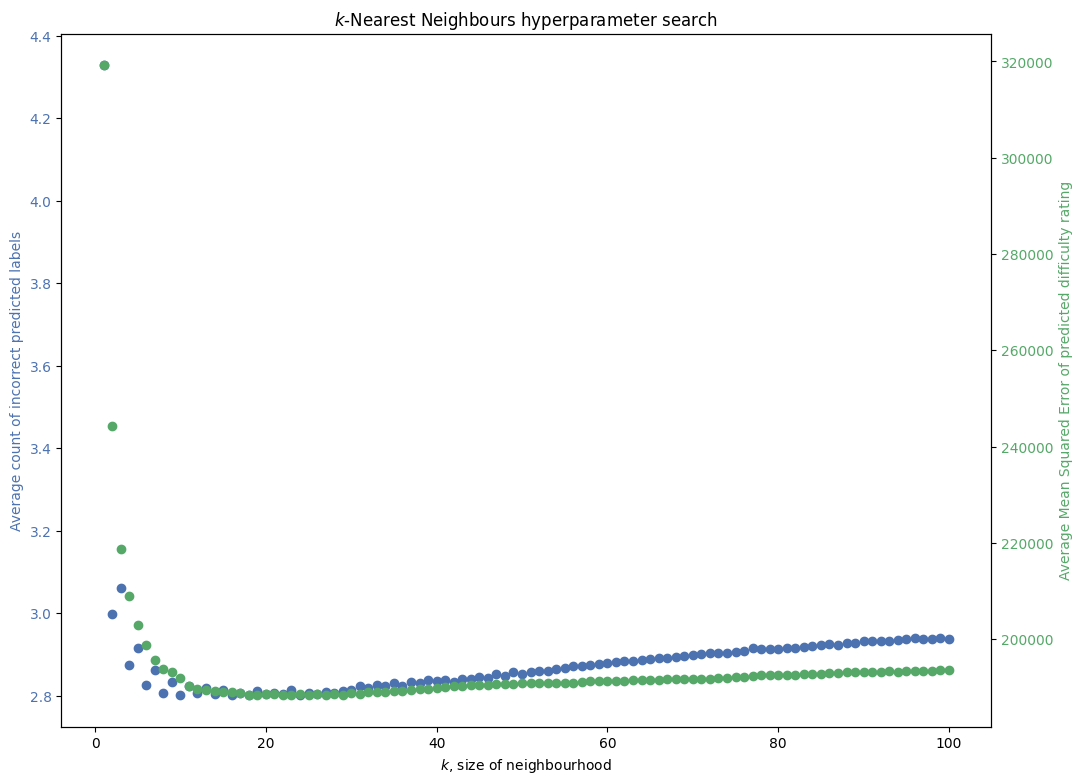

In [2]:
ks = {1: (4.3286, 319206.093), 2: (2.9982, 244267.5313), 3: (3.0605, 218683.9309111054), 4: (2.8736, 208880.44124375), 5: (2.9168, 202880.35857199942), 6: (2.8261, 198739.36374721618), 7: (2.8618, 195666.02572857152), 8: (2.8071, 193846.1564375), 9: (2.8332, 193089.18837530568), 10: (2.8013, 191980.6131389995), 11: (2.8233, 190323.4060768571), 12: (2.8055, 189655.16333957756), 13: (2.8179, 189539.94520887535), 14: (2.8046, 189333.26373418357), 15: (2.8148, 189010.38377910998), 16: (2.8019, 189028.20962148436), 17: (2.8071, 188840.16485951658), 18: (2.8014, 188362.5044450593), 19: (2.8103, 188469.507974792), 20: (2.8051, 188665.01202925027), 21: (2.8063, 188621.3258136047), 22: (2.8034, 188353.55543016343), 23: (2.8134, 188401.9512381849), 24: (2.8011, 188582.90907325843), 25: (2.807, 188429.6637572794), 26: (2.8045, 188589.9226482247), 27: (2.8094, 188473.25617571935), 28: (2.807, 188617.65535663252), 29: (2.8112, 188484.46684090403), 30: (2.8132, 188822.77827088747), 31: (2.8224, 188707.93076410014), 32: (2.8177, 188956.91798974609), 33: (2.8253, 188998.8867660239), 34: (2.8236, 189116.72907724866), 35: (2.8299, 189218.23570261203), 36: (2.8228, 189249.6329107236), 37: (2.8323, 189415.52312220557), 38: (2.8319, 189551.17710006944), 39: (2.8375, 189650.23728027576), 40: (2.8346, 189820.65227743765), 41: (2.8391, 190081.18918465203), 42: (2.8324, 190223.2194064615), 43: (2.8411, 190295.86618171952), 44: (2.8402, 190452.6701664246), 45: (2.8454, 190459.91636775207), 46: (2.8438, 190537.59436862002), 47: (2.8514, 190655.87261190522), 48: (2.8484, 190702.13030680915), 49: (2.8564, 190708.20729825014), 50: (2.8534, 190882.1833818007), 51: (2.8578, 190877.82045336376), 52: (2.8591, 190822.4421423081), 53: (2.8587, 190864.07393022432), 54: (2.864, 190861.44459217959), 55: (2.8671, 190890.70963996678), 56: (2.8714, 190976.50292684857), 57: (2.871, 191118.63040932617), 58: (2.875, 191206.44187865706), 59: (2.8779, 191286.4940272628), 60: (2.8795, 191357.43126183152), 61: (2.8817, 191319.4419095132), 62: (2.8835, 191342.93899102526), 63: (2.884, 191416.3632308643), 64: (2.8855, 191474.03752438966), 65: (2.8888, 191581.23214790563), 66: (2.8908, 191583.75006163787), 67: (2.8919, 191622.63383018397), 68: (2.894, 191726.29896671747), 69: (2.8974, 191679.58251461748), 70: (2.8995, 191697.05789220345), 71: (2.902, 191776.25690559405), 72: (2.9035, 191796.95878074554), 73: (2.9034, 191889.12536689817), 74: (2.9044, 191911.8217025565), 75: (2.9067, 192040.10218595518), 76: (2.9089, 192237.74321604858), 77: (2.9144, 192338.1140219938), 78: (2.9137, 192511.300185914), 79: (2.9143, 192526.9563700055), 80: (2.914, 192515.16443753167), 81: (2.9153, 192542.12333545176), 82: (2.9146, 192633.07690989008), 83: (2.9169, 192661.0202734066), 84: (2.9203, 192772.5047174458), 85: (2.9235, 192793.88778358456), 86: (2.9265, 192880.67549172544), 87: (2.923, 193019.32889427914), 88: (2.9276, 193089.36358225546), 89: (2.9277, 193137.3895553716), 90: (2.9337, 193153.3965285802), 91: (2.9324, 193195.78740853808), 92: (2.9317, 193252.77802830804), 93: (2.9335, 193291.01171755017), 94: (2.9353, 193268.28919019902), 95: (2.9378, 193359.27298212756), 96: (2.9391, 193422.8179359872), 97: (2.9368, 193441.22982668784), 98: (2.9365, 193470.6569294771), 99: (2.939, 193541.92404396483), 100: (2.9372, 193567.30777679037) }

plt.style.use("seaborn-v0_8-deep")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

l = [(x, ks[x][0]) for x in range(1, 101)]
d = [(x, ks[x][1]) for x in range(1, 101)]

col = colors[0]
_, ax = plt.subplots(figsize=(12, 9))
ax.set_xlabel("$k$, size of neighbourhood")
ax.set_ylabel("Average count of incorrect predicted labels", color=col)
ax.scatter(*zip(*l), color=col)
ax.tick_params(axis="y", labelcolor=col)

col = colors[1]
ax2 = ax.twinx() 
ax2.set_ylabel("Average Mean Squared Error of predicted difficulty rating", color=col)
ax2.scatter(*zip(*d), color=col)
ax2.tick_params(axis="y", labelcolor=col)

ax.set_title("$k$-Nearest Neighbours hyperparameter search")

plt.savefig("../report/project/img/knn.png", dpi=250, bbox_inches="tight")